In [1]:
import pandas as pd


In [2]:
#!unzip "drive/MyDrive/Colab Notebooks/dog-breed-identification.zip" -d "drive/MyDrive/Colab Notebooks/"

In [3]:

import tensorflow as tf
import tensorflow_hub as hub
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available|")
print(tf.__version__)


GPU available
2.8.2


### **Getting images and their labels**


In [4]:
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Colab Notebooks/labels.csv")
filenames = ["drive/My Drive/Colab Notebooks/train/"+fname+".jpg" for fname in labels_csv["id"]]

True


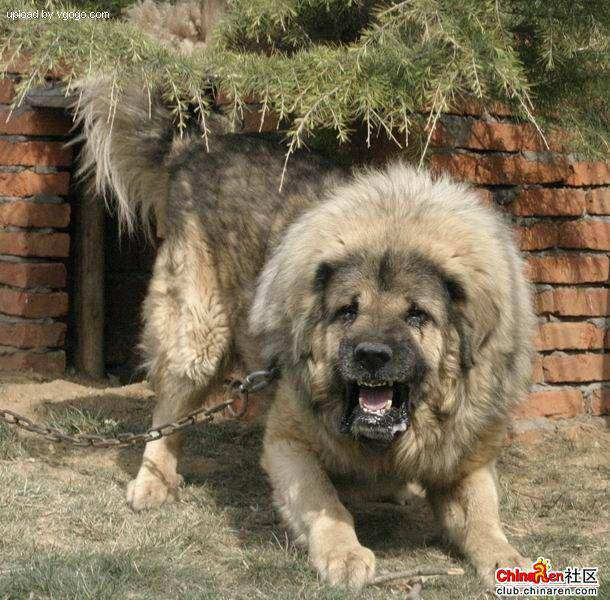

In [5]:
import os
from IPython.display import Image
print(len(os.listdir("drive/My Drive/Colab Notebooks/train"))==len(filenames))
Image(filenames[9000])

In [6]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels


array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [7]:
unique_labels = np.unique(labels)
unique_labels

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [8]:
boolean_labels = [label==unique_labels for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [9]:
print(labels[0])
print(np.where(labels[0]==unique_labels))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


###**Creating the validation set**

In [10]:
X = filenames
y = boolean_labels
from sklearn.model_selection import train_test_split
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state = 42)
len(X_train),len(y_train),len(X_val),len(X_val)
X_train[:2],y_train[:2]

(['drive/My Drive/Colab Notebooks/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Colab Notebooks/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False

###**Preprocessing Images (turning images into Tensors)**
To preprocess our images into Tensors we're going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, **image**
3. Turn our image (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1).
5. Resize the image to be a shape of (224, 224)
6. Return the modified image

In [11]:
IMG_SIZE = 224
def process_image(img_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(img_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])
  return image

###**Turning our data into batches**
Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: **(image, label)**.

In [12]:
def get_image_label(img_path,label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and returns a tuple of (image, label).
  """
  return (process_image(img_path),label)

In [13]:
data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                           tf.constant(y)))
data_batch = data.map(get_image_label)


In [14]:
BATCH_SIZE = 32
def create_data_batches(X,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch
  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

In [15]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [16]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

###**Visualizing Data Batches**

In [17]:
import matplotlib.pyplot as plt

def show_25_images(images, labels):
  plt.figure(figsize=(20,10))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.title(unique_labels[labels[i].argmax()])
    plt.xticks([])
    plt.yticks([])

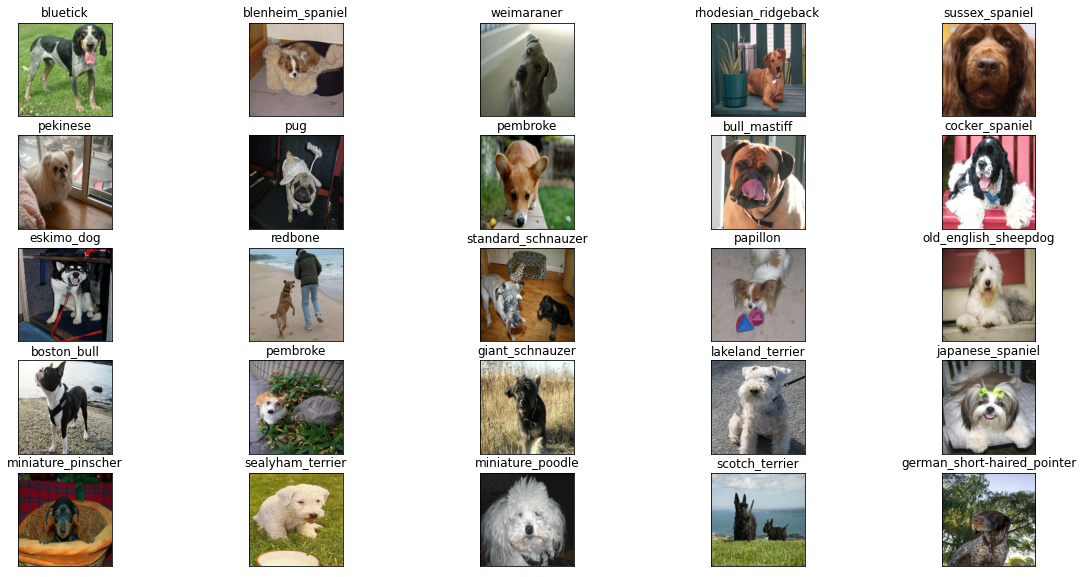

In [18]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

In [19]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_labels)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [20]:
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
  print("Building model with:", model_url)
  # Setup the model layers
  model = tf.keras.Sequential([
                       hub.KerasLayer(model_url),
                       tf.keras.layers.Dense(units=output_shape,
                                             activation="softmax")
  ])
  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(input_shape)

  return model


In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


##**Creating callbacks**
Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

##**TensorBoard Callback**
To setup a TensorBoard callback, we need to do 3 things:

1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function.
3. Visualize our models training logs with the %tensorboard magic function (we'll do this after model training).

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

def create_tensorboard_callback():
  logdir = os.path.join("drive/MyDrive/Colab Notebooks/logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

##**Early Stopping Callback**
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

In [ ]:
NUM_EPOCHS = 100  # @param {type:"slider", min:100, max:1000, step:100}

In [ ]:
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  model = create_model()
  tensorboard = create_tensorboard_callback()
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard,early_stopping])
  return model


In [ ]:
#model = train_model()

In [ ]:
#%tensorboard --logdir drive/MyDrive/Colab\ Notebooks/logs

In [ ]:
def save_model(model, suffix=""):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  model_dir = os.path.join("drive/MyDrive/Colab Notebooks/models",datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = model_dir + "-"+suffix+".h5"
  model.save(model_path)
  print(f"Saving model to: {model_path}...")
  return model_path

In [ ]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}") 
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
save_model(model, suffix="1000-images-mobilenetv2-Adam")


In [ ]:
loaded_1000_image_model = load_model('drive/MyDrive/Colab Notebooks/models/20220722-20431658522636-1000-images-mobilenetv2-Adam.h5')


In [ ]:
#model.evaluate(val_data)

In [ ]:
loaded_1000_image_model.evaluate(val_data)


7/7 [==============================] - 106s 15s/step - loss: 1.2297 - accuracy: 0.6800


[1.229742169380188, 0.6800000071525574]

In [ ]:
predictions = loaded_1000_image_model.predict(val_data)
predictions

array([[6.3363104e-03, 1.8098128e-05, 6.4657460e-04, ..., 4.0324079e-04,
        6.9895614e-05, 2.4156109e-03],
       [2.0504366e-03, 9.5214986e-04, 2.4871172e-02, ..., 1.4210761e-03,
        5.0476770e-04, 2.3164651e-04],
       [5.4086726e-05, 1.8242637e-03, 3.2371935e-04, ..., 5.7219854e-04,
        1.8332552e-04, 3.6437620e-04],
       ...,
       [2.7644427e-07, 1.3009936e-05, 3.9972470e-05, ..., 1.1816747e-04,
        1.8281254e-04, 2.3019169e-05],
       [3.3672736e-03, 6.0043629e-04, 4.1537196e-04, ..., 1.4381763e-04,
        8.1124250e-05, 6.7809103e-03],
       [1.0616858e-03, 5.9042279e-05, 2.7502942e-04, ..., 7.2717643e-03,
        8.4462849e-04, 2.1228561e-05]], dtype=float32)

In [ ]:
print(f"max value = {np.max(predictions[0])}")
print(f"sum = {np.sum(predictions[0])}")
print(f"index of max value = {np.argmax(predictions[0])}")
print(f"breed at index of max value = {unique_labels[np.argmax(predictions[0])]}")

max value = 0.20949217677116394
sum = 0.9999999403953552
index of max value = 17
breed at index of max value = border_terrier


In [ ]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_labels[np.argmax(prediction_probabilities)]

In [ ]:
def unbatchify(data):
  images = []
  data_labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    data_labels.append(get_pred_label(label))
  return images,data_labels

In [ ]:
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

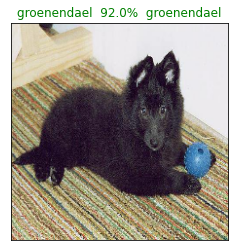

In [ ]:
def plot_pred(pred_probs,images,labels,n):
  pred_prob,image,label = pred_probs[n],images[n],labels[n]
  pred_label = get_pred_label(pred_prob)
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  if(pred_label==label):
    color = "green"
  else:
    color = "red"
  plt.title(f"{pred_label}  {np.round(np.max(pred_prob)*100)}%  {label}",color=color)
plot_pred(predictions,val_images,val_labels,77)

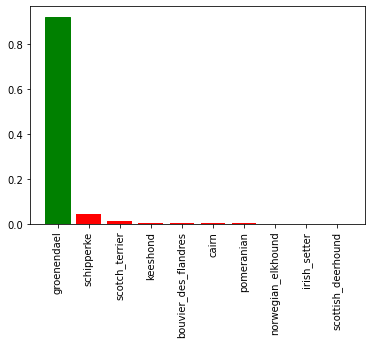

In [ ]:
def plot_pred_conf(pred_probs,labels,n):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob,label=pred_probs[n],labels[n]
  pred_label = get_pred_label(pred_prob)
  sorted_pred_prob = np.argsort(pred_prob)
  top_10_pred_prob = pred_prob[sorted_pred_prob[-10:][::-1]]
  top_10_labels = unique_labels[sorted_pred_prob[-10:][::-1]]

  top_10_plot = plt.bar(top_10_labels,top_10_pred_prob,color="red")
  plt.xticks(rotation="vertical")
  if np.isin(label,top_10_labels):
    top_10_plot[np.argmax(label==top_10_labels)].set_color("green")
plot_pred_conf(predictions,val_labels,77)


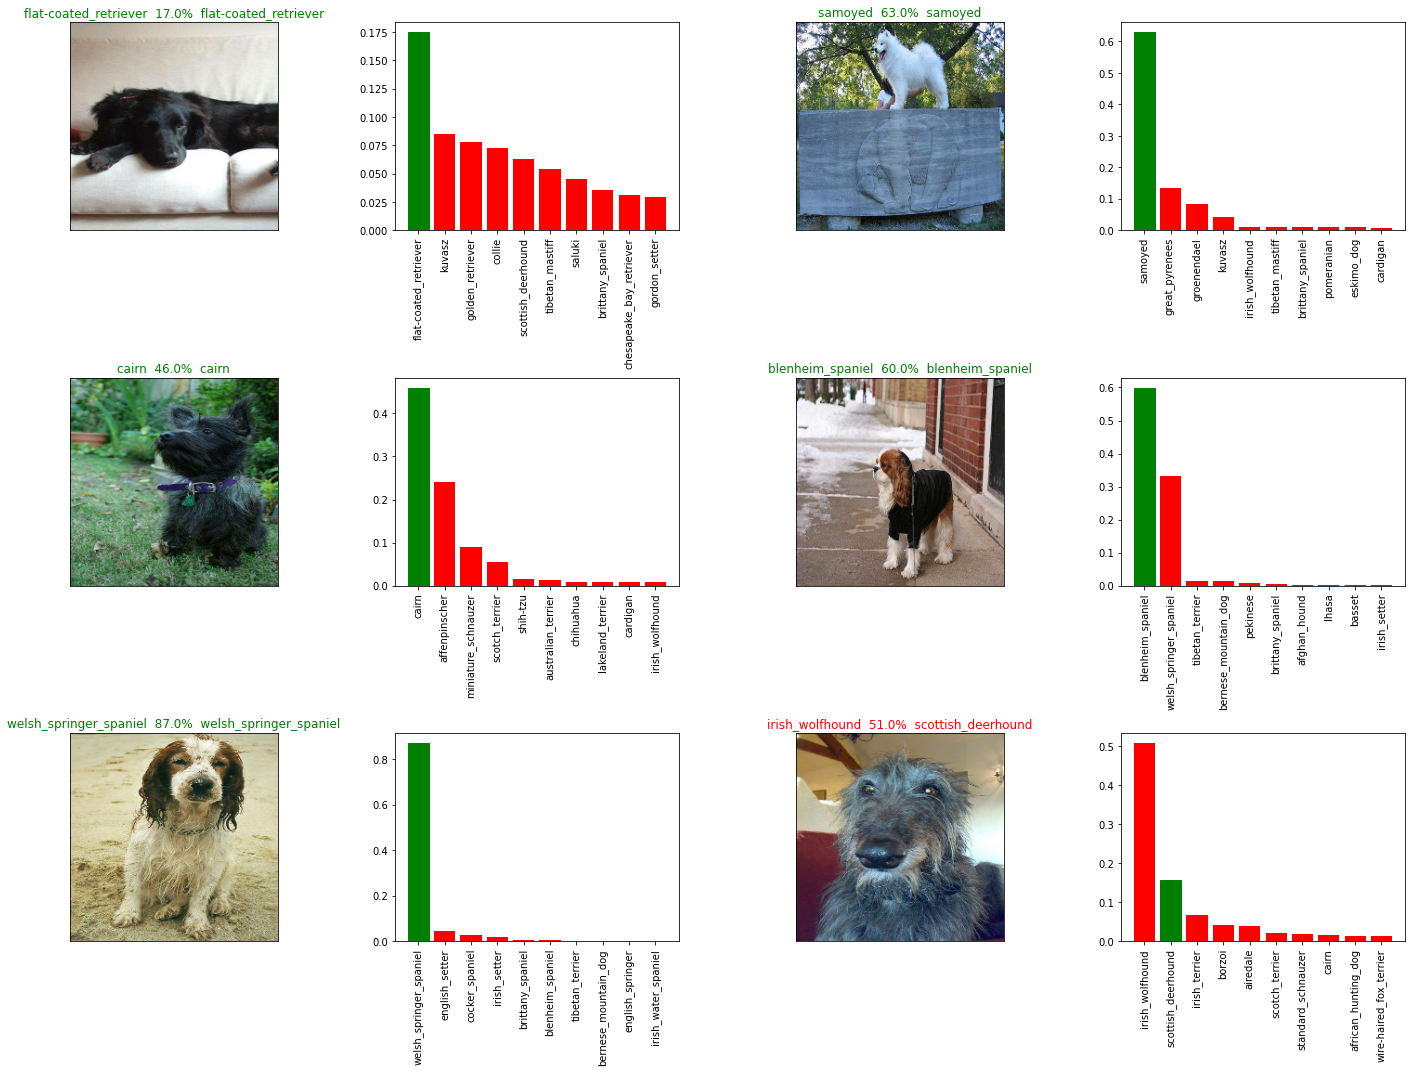

In [ ]:
i_mult = 20
rows = 3
col = 2
num_images = rows*col
plt.figure(figsize=(10*col,5*rows))
for i in range(num_images):
   plt.subplot(rows,2*col,2*i+1)
   plot_pred(predictions,val_images,val_labels,i+i_mult)
   plt.subplot(rows,2*col,2*i+2)
   plot_pred_conf(predictions,val_labels,i+i_mult)
plt.tight_layout(h_pad=1)
plt.show()